# Some exploration of methods

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import cross_validate
from sklearn.feature_selection import SelectFromModel, mutual_info_regression, SelectPercentile
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import XGBRegressor
import pickle
from scipy.stats import pearsonr




In [7]:
def load_data(phenotype="mass"):
    """Load data from RDS file"""
    print("LOADING DATA")
    data_path = "~//..//..//..//..//work//didrikls//ProjectThesis//data//"
    print("R script completed successfully")
    rds_path = data_path + phenotype + ".feather"
    mass_residuals = pd.read_feather(rds_path)
    print("DATA LOADED")
    return mass_residuals


In [8]:
mass_resids = load_data()
mass_resids.columns[:10]

LOADING DATA
R script completed successfully
DATA LOADED


Index(['ringnr', 'ID', 'FID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE', 'SNPa29779_A',
       'SNPa117082_T', 'SNPa445460_A'],
      dtype='object')

In [15]:
mass_resids.ringnr.iloc[10:50].to_frame().reset_index().head()

,index,ringnr
0,10,8168605
1,11,8168606
2,12,8168613
3,13,8168614
4,14,8168635


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

corrs_df = pd.read_pickle("results/corrs_df.pkl")
MSE_df = pd.read_pickle("results/MSE_df.pkl")
feat_perc_df = pd.read_pickle("results/feat_perc_df.pkl")

plot_df = pd.read_pickle("results/plot_df.pkl")

dfs = [corrs_df, MSE_df, feat_perc_df]

for df in dfs:
    name_dict = {}
    for name in df.columns:
        if "CV" in name:
            new_name = name.split("CV")[0] + "Corr"
        else:
            new_name = name
        name_dict[name] = new_name
    df.rename(columns = name_dict, inplace=True)

name_dict = {
    "GBLUPM":"GBLUP",
    "GBLUP": "GBLUP",
    "xgboostCorr": "xgboost",
    "xgboostT": "xgboost",
    "catboostCorr": "catboost",
    "lightGBMCorr" : "lightGBM",
    "catboostT": "catboost",
    "xgboostEGT" : "xgboostEG"
}


plot_df = pd.DataFrame(columns=["model", "corr", "MSE", "feat_perc", "phenotype"])
phenotype = "bodymass"
for name in corrs_df.columns:
    if name == "xgboostT" or name == "catboostT" or name == "GBLUP" or name == "xgboostEGT":
        phenotype = "tarsus"
    elif name == "xgboostTelastic":
        continue
    else:
        phenotype = "bodymass"
    if name in name_dict.keys():
        new_name = name_dict[name]
    else:
        new_name = name
    for i in range(corrs_df.shape[0]):
        if new_name == "GBLUP":
            plot_df.loc[len(plot_df)] = [new_name, corrs_df.iloc[i][name], MSE_df.iloc[i][name], None, phenotype]
        else:
            plot_df.loc[len(plot_df)] = [new_name, corrs_df.iloc[i][name], MSE_df.iloc[i][name], feat_perc_df.iloc[i][name], phenotype]



In [2]:
plot_df_EG = plot_df[plot_df.model.isin(["GBLUP", "xgboostEG", "catBoostEG" ])]
plot_df_split = plot_df[~plot_df.model.isin(["GBLUP", "xgboostEG", "catBoostEG"])]
plot_df_GBLUP = plot_df[~plot_df.model.isin(["xgboostEG", "catBoostEG"])]

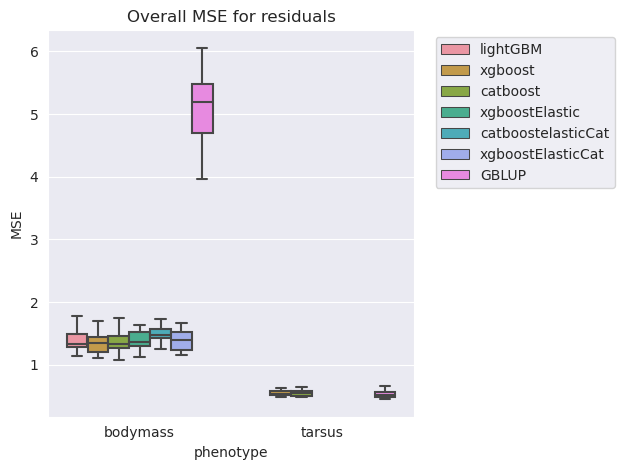

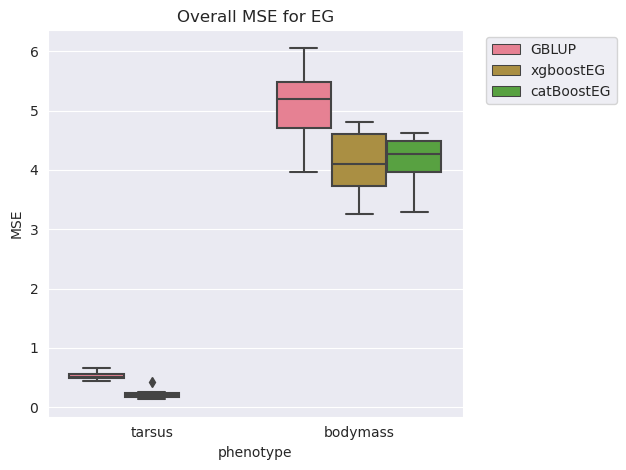

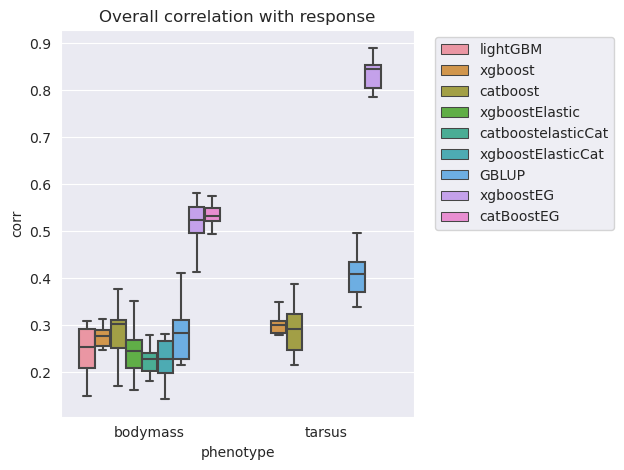

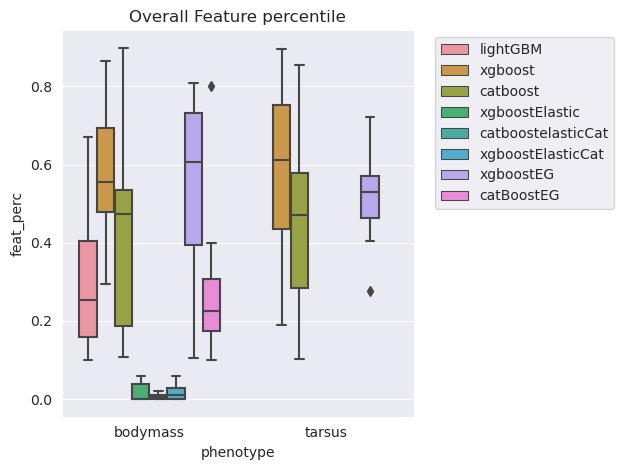

In [5]:
sns.set_style("darkgrid")
sns.set_palette(palette="husl")

plt.figure(4)
plt.title("Overall MSE for residuals")
sns.boxplot(data=plot_df_GBLUP,x="phenotype",y="MSE",hue="model",  orient = "v", width=.8)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()


plt.figure(5)
plt.title("Overall MSE for EG")
sns.boxplot(data=plot_df_EG,x="phenotype",y="MSE",hue="model",  orient = "v", width=.8)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()



plt.figure(6)
plt.title("Overall correlation with response")
sns.boxplot(data=plot_df,x="phenotype",y="corr",hue="model",  orient = "v", width=.8,showfliers=False)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()


plt.figure(7)
plt.title("Overall Feature percentile")
sns.boxplot(data=plot_df.loc[~plot_df.model.isin(["GBLUP"])],x="phenotype",y="feat_perc",hue="model",  orient = "v", width=.8)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()


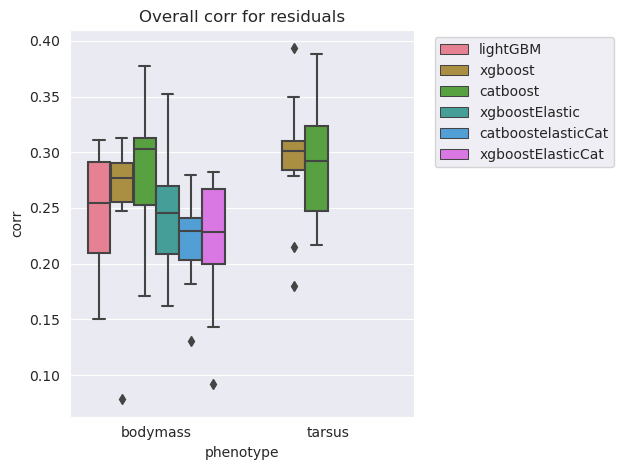

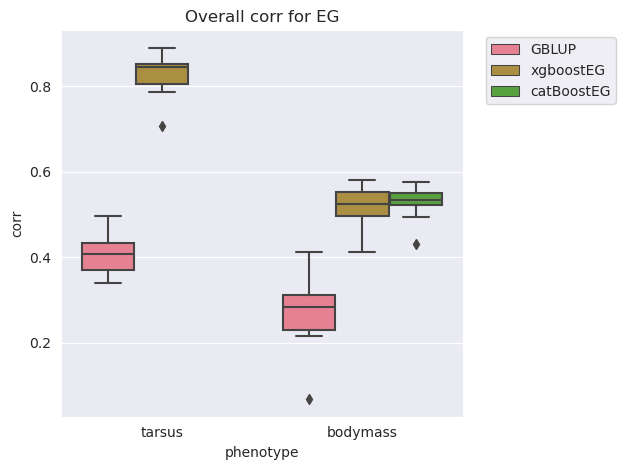

In [6]:
plt.figure()
plt.title("Overall corr for residuals")
sns.boxplot(data=plot_df_split,x="phenotype",y="corr",hue="model",  orient = "v", width=.8)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()


plt.figure()
plt.title("Overall corr for EG")
sns.boxplot(data=plot_df_EG,x="phenotype",y="corr",hue="model",  orient = "v", width=.8)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [28]:
import pickle
with open(f"models/catBoostEG/catBoostEG.pkl", "rb") as f:
    catboostmod = pickle.load(f)

with open(f"models/xgboostEG/xgboostEG.pkl", "rb") as f:
    xgboostmod = pickle.load(f)

with open(f"models/xgboostEG/xgboostEG_best_sel.pkl", "rb") as f:
    xgboost_sel = pickle.load(f)

In [1]:
import os
import subprocess
import pandas as pd



def load_data(phenotype="mass"):
    """Load data from RDS file"""
    print("LOADING DATA")
    data_path = "/../../../../../../work/didrikls/ProjectThesis/data/"
    print("Running R script to load data")
    if not os.path.isfile(data_path + "envGene_" + phenotype + ".feather"):
        res = subprocess.call(
            f"Rscript --vanilla envGendataloader.R {phenotype}", shell=True
        )
    else:
        res = 0

    if res == 0:
        print("R script completed successfully")
        rds_path = data_path + "envGene_" + phenotype + ".feather"
        mass_residuals = pd.read_feather(rds_path)
        print("DATA LOADED")
        return mass_residuals
    else:
        raise Exception("Could not load data")
    

phenotype = "mass"
mass_residuals = load_data(phenotype=phenotype)
SNP_data = mass_residuals.iloc[:, 2:]
# SNP_data.fillna(0, inplace=True)
# SNP_data = SNP_data.astype(int)
# SNP_data = SNP_data.astype("category")
SNP_data.hatchyear = SNP_data.hatchyear.astype(int)
SNP_data.island_current = SNP_data.island_current.astype(int)
Y = mass_residuals.loc[:, phenotype]
ringnrs = mass_residuals.ringnr

LOADING DATA
Running R script to load data
R script completed successfully
DATA LOADED


In [6]:
import shap
from sklearn.model_selection import KFold, GroupKFold
X = SNP_data

kf = GroupKFold(n_splits=10)
for fold, (train_val_index, test_index) in enumerate(kf.split(X, groups=ringnrs)):
    X_train_val, X_test = (
    X.iloc[train_val_index],
    X.iloc[test_index],
    )
    Y_train_val, Y_test = (
    Y.iloc[train_val_index],
    Y.iloc[test_index],
    )
    print(train_val_index[:10])
    print(test_index[:10])
    break

# xgboostmod.fit(X_train_val, Y_train_val)
# explainer = shap.Explainer(xgboostmod)
# shap_values = explainer.shap_values(X_train_val)

[0 1 2 3 4 5 6 7 8 9]
[ 31  32  39 165 166 167 168 295 314 315]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


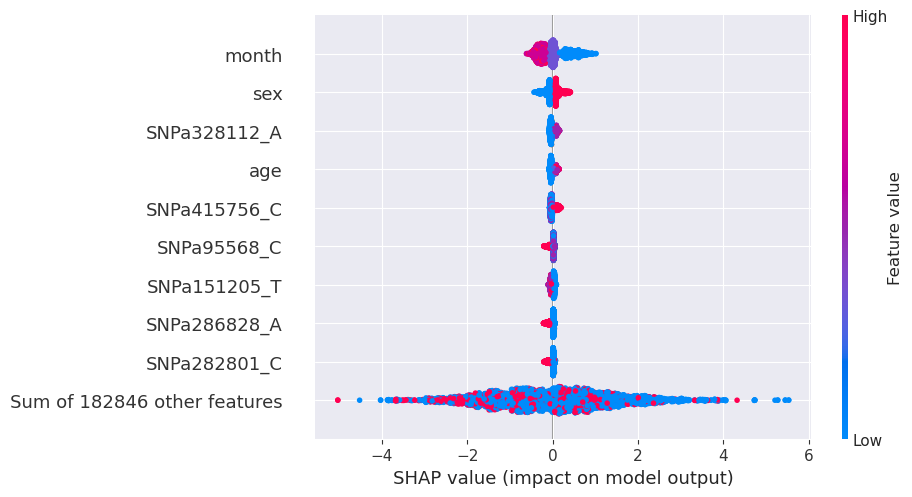

In [40]:
shap_values2 = explainer(X_train_val)
shap.plots.beeswarm(shap_values2)